# Digit bounding box

From our exploratory data analysis tutorials we have found that the digits in dataset **A** and **B** have unnecessary non digit areas. In this tutorial we are going to get a more focused crop of the digits. Functions from the [opencv](https://opencv.org/) library will be very handy for this purpose.

In [294]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import glob
import cv2 # the opencv library
import matplotlib.pyplot as plt

In [22]:
FIG_WIDTH=16 # Width of figure
HEIGHT_PER_ROW=3 # Height of each row when showing a figure which consists of multiple rows
project_dir='..'

In [6]:
# All the images have .png extension. We can get all the filepaths that have .png extensions by using the 
# os.glob.glob() function 
paths_train_a=glob.glob(os.path.join(project_dir,'Final_DB','training-a','*.png'))

Let's read an image from dataset **A** as grayscale image and plot it.

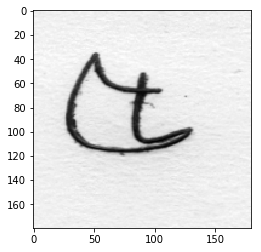

In [358]:
img_gray=cv2.imread(paths_train_a[0],cv2.IMREAD_GRAYSCALE) # read image, image size is 180x180
plt.imshow(img_gray,cmap='gray')
plt.show()

We are going to invert the image to make the background(non digit area) black and foreground (digit) white.

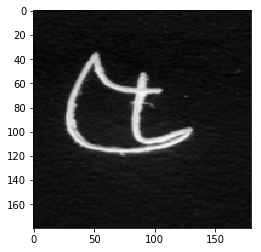

In [359]:
img_gray=255-img_gray
plt.imshow(img_gray,cmap='gray')
plt.show()

Next, we shall transform the grayscale image to a binary one. To do this we have to compare each pixel value against a threshold. The threshold will be calculate using [Otsu's](http://www.labbookpages.co.uk/software/imgProc/otsuThreshold.html) method. In short, Otsu's method divides the image pixel values into two groups based on each integer value between 0 and 255 and adds the weighted variance of the two groups. The integer value for which the sum of weighted variance is lowest is selected as the threshold. Passing the `cv2.THRESH_OTSU` flag in the `threshold()` function from cv2 library does this work for us. The function returns the binary image along with the threshold used.

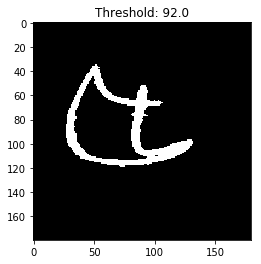

In [360]:
(thresh, img_bin) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_OTSU)
plt.imshow(img_bin,cmap='gray')
plt.title('Threshold: {}'.format(thresh))
plt.show()

Next, we shall extract the contours by using the `findCountours()` function. This function alters the source image. So we are going to pass a copy of the binary image.

In [364]:
_,contours,_ = cv2.findContours(img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Let's draw the contours on the grayscaleimage using the `drawContours()` function. This function alters the source image. So we are going to pass a copy of the grayscale image each time we want a draw a contour on it.

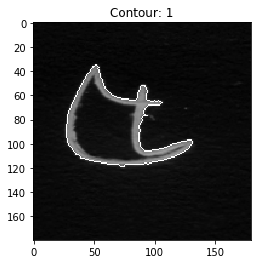

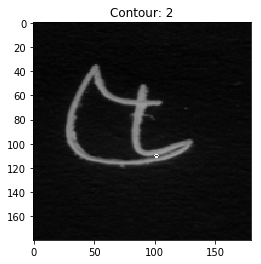

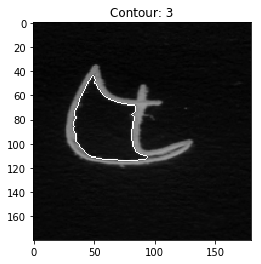

In [381]:
for i in range(len(contours)):
    img_gray_cont=img_gray.copy() 
    cv2.drawContours(img_gray_cont, contours, i,255, 1)
    plt.imshow(img_gray_cont,cmap='gray')
    plt.title('Contour: {}'.format(i+1))
    plt.show()

We are only interested in the contour with the largest area. So we shall sort the contours by area take the largest one.

In [367]:
countours_largest = sorted(contours, key=lambda x: cv2.contourArea(x))[-1]

Next, we want to draw a rectangle around this contour. This can be done using the `boundingRect()` function.

In [368]:
bb=cv2.boundingRect(countours_largest)

Let's observe the quality of the bounding box.

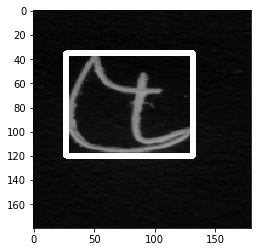

In [370]:
# pt1 and pt2 are terminal coordinates of the diagonal of the rectangle
pt1=(bb[0],bb[1]) # upper coordinates 
pt2=(bb[0]+bb[2],bb[1]+bb[3]) # lower coordinates
img_gray_bb=img_gray.copy()
cv2.rectangle(img_gray_bb,pt1,pt2,255,3)
plt.imshow(img_gray_bb,cmap='gray')
plt.show()

The rectangle sides clips the boudaries of the digits which is unwanted. We can pad the rectangle by a few pixels to eliminate this phenomenon. Also we have to make sure that the rectangles do not go out of the image boundaries while being padded.

In [371]:
PIXEL_ADJ=3 # the number of padding pixels
pt1=[bb[0],bb[1]]
pt2=[bb[0]+bb[2],bb[1]+bb[3]]

if pt1[0]-PIXEL_ADJ>=0: # upper x coordinate
    pt1[0]=pt1[0]-PIXEL_ADJ
else: pt1[0]=0
if pt1[1]-PIXEL_ADJ>=0: # upper y coordinate
    pt1[1]=pt1[1]-PIXEL_ADJ
else: pt1[1]=0

if pt2[0]+PIXEL_ADJ<=img_gray.shape[0]: # lower x coordinate
    pt2[0]=pt2[0]+PIXEL_ADJ
else: pt2[0]=img_gray.shape[0]
if pt2[1]+PIXEL_ADJ<=img_gray.shape[1]: # lower y coordinate
    pt2[1]=pt2[1]+PIXEL_ADJ
else: pt2[1]=img_gray.shape[1]
pt1=tuple(pt1)
pt2=tuple(pt2)

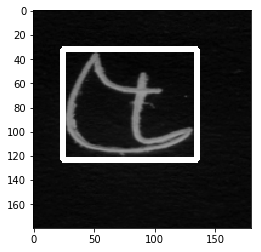

In [373]:
img_gray_bb=img_gray.copy()
cv2.rectangle(img_gray_bb,pt1,pt2,255,3)
plt.imshow(img_gray_bb,cmap='gray')
plt.show()

Padding gives a much better crop. But we are not done yet. Some images have gaps in pen strokes which results in incorrect contours. Let's observe such an example.

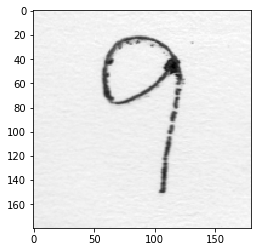

In [391]:
img_gray=cv2.imread(paths_train_a[61],cv2.IMREAD_GRAYSCALE) # read image, image size is 180x180
plt.imshow(img_gray,cmap='gray')
plt.show()

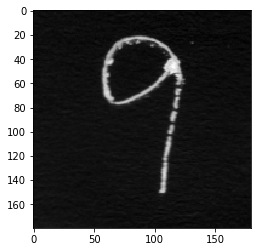

In [392]:
img_gray=255-img_gray
plt.imshow(img_gray,cmap='gray')
plt.show()

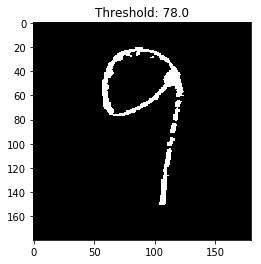

In [390]:
(thresh, img_bin) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_OTSU)
plt.imshow(img_bin,cmap='gray')
plt.title('Threshold: {}'.format(thresh))
plt.show()

The binary image has discontinuous pen stroke which will erroneously result in multiple contours.

In [394]:
_,contours,_ = cv2.findContours(img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

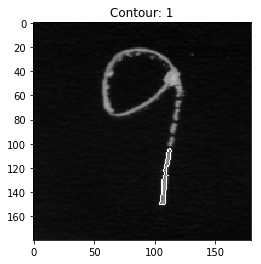

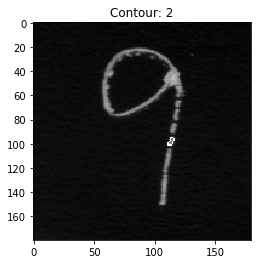

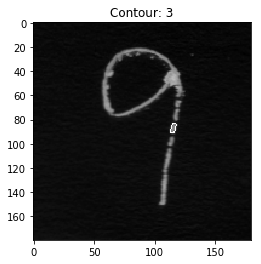

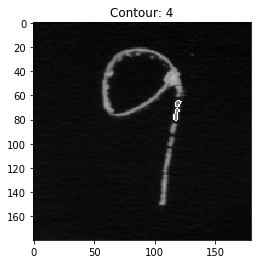

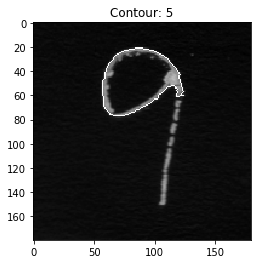

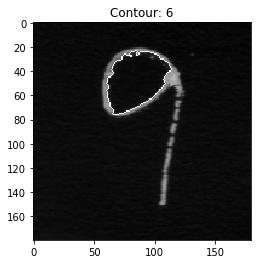

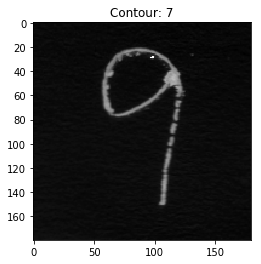

In [396]:
for i in range(len(contours)):
    img_gray_cont=img_gray.copy() 
    cv2.drawContours(img_gray_cont, contours, i,255, 1)
    plt.imshow(img_gray_cont,cmap='gray')
    plt.title('Contour: {}'.format(i+1))
    plt.show()

None of the contours will give us an accurate bounding box. To solve this problem we shall pass the binary image through a **dilation** operation followed by an **erosion** operation (the aggregation of these two operation is called **closing**). Details of these two operations is described [here.](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)

Dilation is a morphological operation which takes two inputs, an image and a _structuring element_ called **kernel** and outputs a dilated image. The kernel slides through the image as in 2D convolution). A pixel element is ‘1’ if atleast one pixel under the kernel is ‘1’. So it increases the white region in the image and joins the broken parts of the image.

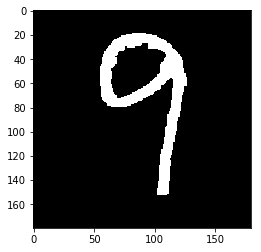

In [399]:
kernel = np.ones((5,5),np.uint8)
img_dilate=cv2.dilate(img_bin,kernel,iterations = 1)
plt.imshow(img_dilate,cmap='gray')
plt.show()

After filling the gaps, we want to erode the edges of the digit and reduce its thickness. In the erosion operation, the kernel slides through the image. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

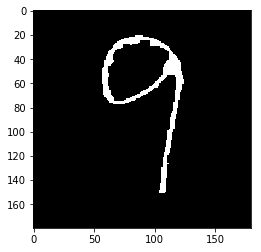

In [400]:
img_erode=cv2.erode(img_dilate,kernel,iterations = 1)
plt.imshow(img_erode,cmap='gray')
plt.show()

The resulting image does not have any broken pen strokes. Let's incorporate this in our image cropping procedure and place everything in a function. Then we shall apply the function on a few samples and observe the results.

In [401]:
def img_bb(path):
    # shows image with bounding box
    img_gray=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # read image, image size is 180x180
    img_gray=255-img_gray
    
    (thresh, img_bin) = cv2.threshold(img_gray, 128, 255, cv2.THRESH_OTSU)
    
    kernel = np.ones((5,5),np.uint8)
    img_dilate=cv2.dilate(img_bin,kernel,iterations = 1)
    img_erode=cv2.erode(img_dilate,kernel,iterations = 1)
    
    _,contours,_ = cv2.findContours(img_erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    countours_largest = sorted(contours, key=lambda x: cv2.contourArea(x))[-1]
    bb=cv2.boundingRect(countours_largest)
    
    pt1=[bb[0],bb[1]]
    pt2=[bb[0]+bb[2],bb[1]+bb[3]]
    # pt1 and pt2 are terminal coordinates of the diagonal of the rectangle
    if pt1[0]-PIXEL_ADJ>=0: # upper x coordinate
        pt1[0]=pt1[0]-PIXEL_ADJ
    else: pt1[0]=0
    if pt1[1]-PIXEL_ADJ>=0: # upper y coordinate
        pt1[1]=pt1[1]-PIXEL_ADJ
    else: pt1[1]=0
    if pt2[0]+PIXEL_ADJ<=img_gray.shape[0]: # lower x coordinate
        pt2[0]=pt2[0]+PIXEL_ADJ
    else: pt2[0]=img_gray.shape[0]
    if pt2[1]+PIXEL_ADJ<=img_gray.shape[0]: # lower y coordinate
        pt2[1]=pt2[1]+PIXEL_ADJ
    else: pt2[1]=img_gray.shape[0]
    pt1=tuple(pt1)
    pt2=tuple(pt2)
    
    img_gray_bb=img_gray.copy()
    cv2.rectangle(img_gray_bb,pt1,pt2,255,3)
    
    return img_gray_bb
    
def imshow_group(X,n_per_row=10):
    # shows a group of images
    n_sample=len(X)
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,HEIGHT_PER_ROW*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.show()

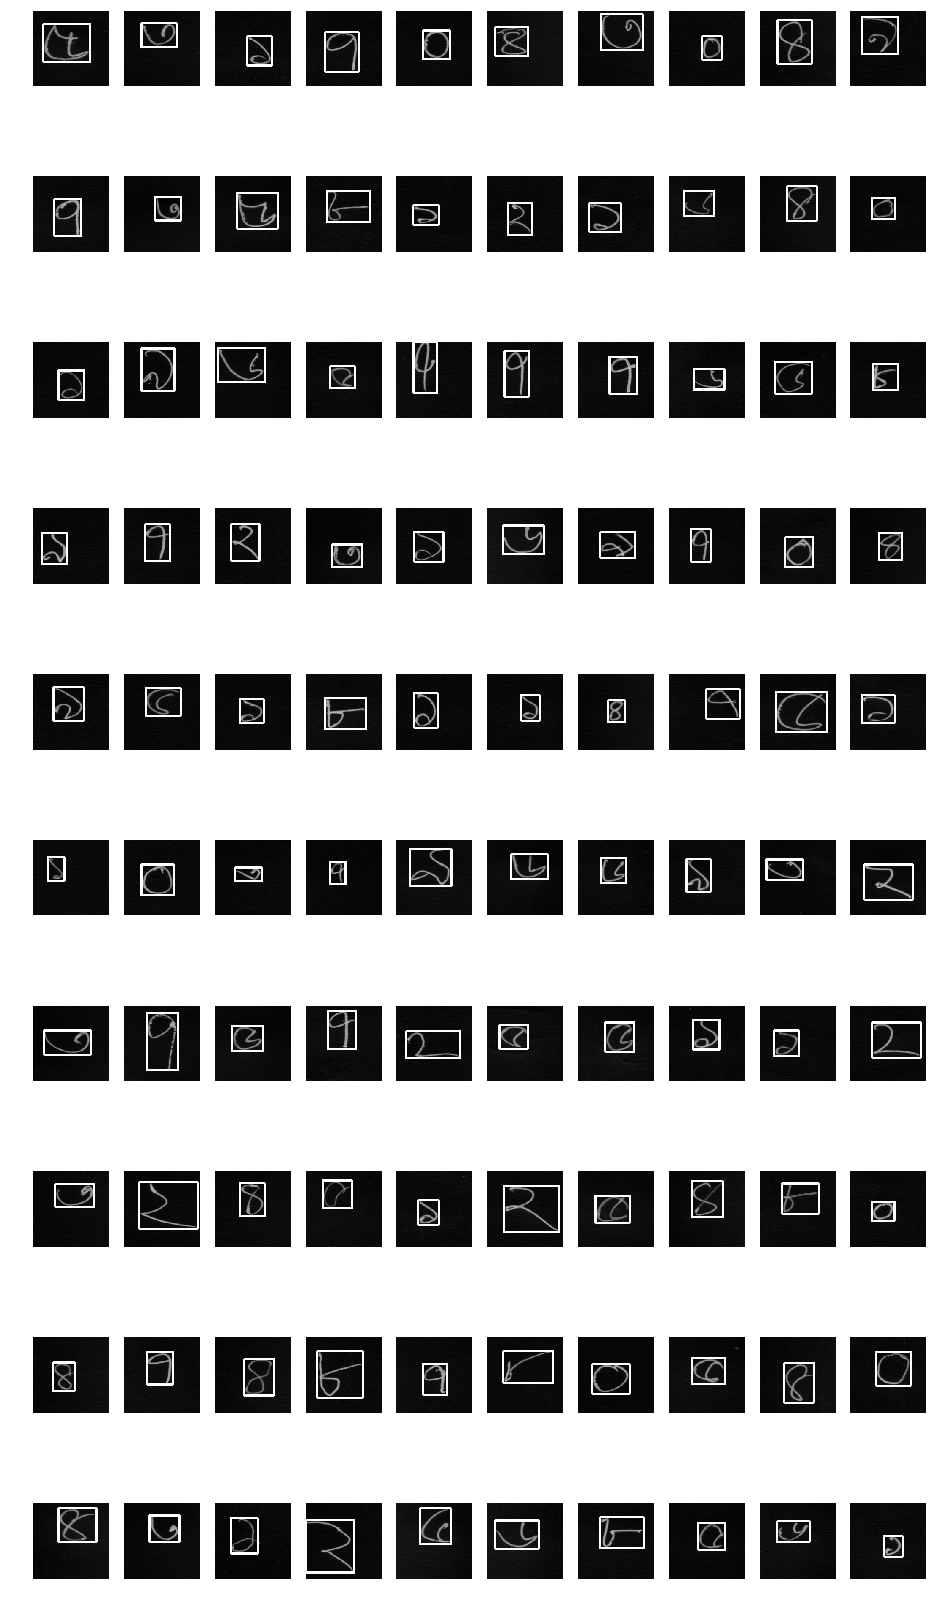

In [402]:
X_sample_a=[img_bb(path) for path in paths_train_a[:100]]
imshow_group(X_sample_a)

The results are quite satisfactory. Let's see if the above procedure works for dataset **B**.

In [403]:
paths_train_b=glob.glob(os.path.join(project_dir,'Final_DB','training-b','*.png'))

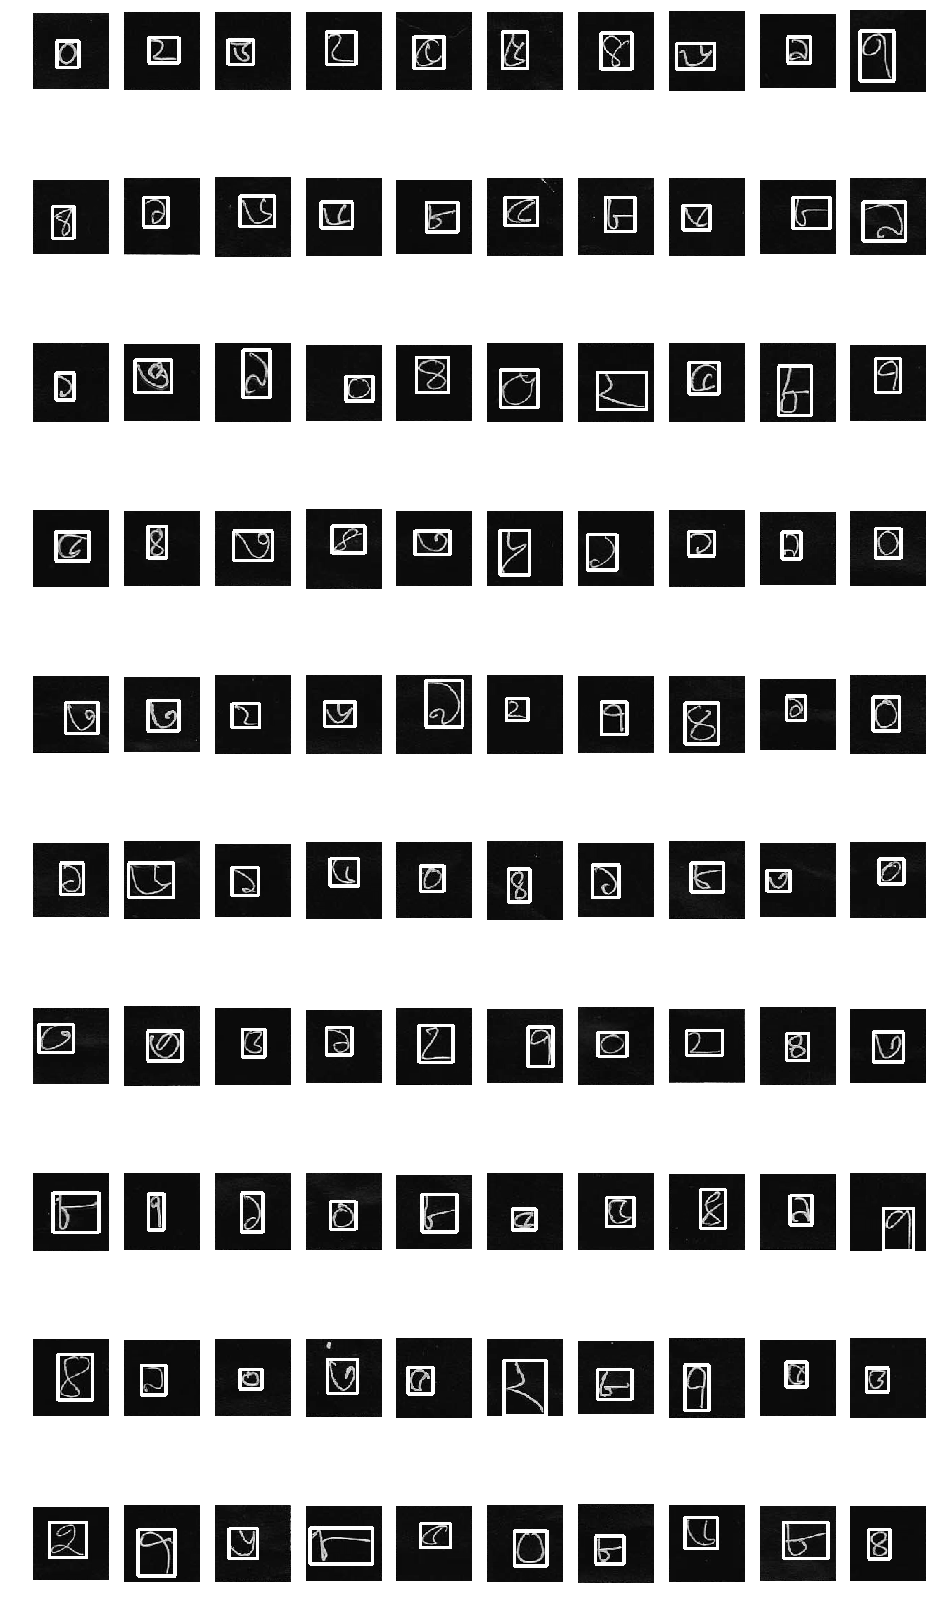

In [404]:
X_sample_b=np.array([img_bb(path) for path in paths_train_b[:100]])
imshow_group(X_sample_b)

It seems to be working for dataset **B** also.